# Clustering - Expectation Maximization - predict geyser eruption times
------------------------------------------------------------------------

### ```1.1.0``` Import Packages

In [1]:
# import stuff
import copy
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score,r2_score

### ```2.1.0``` Reading in data and processing

In [2]:
# read csv
df = pd.read_csv (r'data/oldfaithful.csv')

### ```2.1.1``` Splitting data set into test and train 

In [3]:
# train test split data
df_train, df_test = train_test_split(df, test_size=0.08)

In [4]:
# 250 samples in training 
df_train.shape

(250, 3)

In [5]:
# df_train
df_train

,No,duration,waiting
96,97,4.667,84
134,135,1.833,46
225,226,4.117,79
56,57,3.717,71
179,180,4.167,74
...,...,...,...
255,256,3.817,80
67,68,4.700,78
130,131,1.867,45
167,168,5.000,88


### ```3.1.0``` Visualizing the raw data

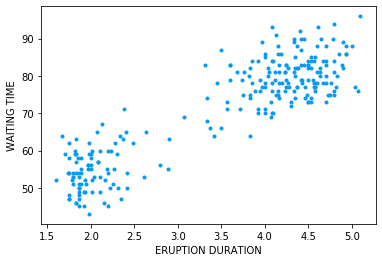

In [6]:
# visualizing the training data
# clearly 2 separate clusters needed
plt.plot(df_train['duration'],df_train['waiting'],'.',color='xkcd:azure')
plt.xlabel('ERUPTION DURATION')
plt.ylabel('WAITING TIME')
plt.show()

### ```4.1.0``` Expectation Maximization and Linear Regression

In [7]:
# helper functions
def train_em(x,k = 2,max_iter=100):

    n = x.shape[0]
    phi = np.random.rand(k,1)
    # normalize summation(phi) = 1
    phi = phi/np.sum(phi)
    u = np.random.rand(k,1)
    sigma = np.random.rand(k,1)    
    w = np.ndarray(shape=(n,k))
    prev = np.ndarray(shape=(1))
    n_iter = 0
    done_flag = False
    
   # E step wij
    while(n_iter < max_iter and done_flag != True):
        
        p_tot = np.zeros((n,1,1))
        p = np.zeros((n,k,1))
        
        for i in range(n):
            for j in range(k):
                e_term = np.exp(- ( (x[i] - u[j]).T * (x[i] - u[j]) ) / (2 * sigma[j]**2))
                const_term = 1 / ( (2*np.pi)**(1/2) * sigma[j] )
                p[i][j] = ( const_term * e_term * phi[j] )
                p_tot[i] += p[i][j]

        prev = copy.deepcopy(w)
        for i in range(n):
                for j in range(k):
                    w[i][j] = p[i][j] / p_tot[i]
        
        # M step   
        for j in range(k):
            wij_xjuj = 1
            wij_xj = 1
            wij = 1

            for i in range(n):
                wij_xj +=  w[i][j] * x[i]
                wij += w[i][j]

            # mean
            u[j] = wij_xj / wij
            
            for i in range(n):
                wij_xjuj += w[i][j] * (x[i]-u[j])**2   
            # std
            sigma[j] = ( wij_xjuj / wij )**(1/2)
                
            # phi
            phi[j] = wij / n
            
        
        if (prev == w).all():
            done_flag = True    
            
        n_iter+=1
    return u, sigma, phi, w


def predict_em_wij(x,u,sigma,phi,k=2):
    n = x.shape[0]
    w = np.ndarray(shape=(n,k))
    p_tot = np.zeros((n,1,1))
    p = np.zeros((n,k,1))    
    for i in range(n):
        for j in range(k):
            e_term = np.exp(- ( (x[i] - u[j]).T * (x[i] - u[j]) ) / (2 * sigma[j]**2))
            const_term = 1 / ( (2*np.pi)**(1/2) * sigma[j] )
            p[i][j] = ( const_term * e_term * phi[j] )
            p_tot[i] += p[i][j]
    prev = copy.deepcopy(w)
    for i in range(n):
        for j in range(k):
            w[i][j] = p[i][j] / p_tot[i]
    return w
    
def clusterize(w):
    l0 = []
    l1 = []
    for i in range(w.shape[0]):
            if w[i][1] > w[i][0]:
                l0.append(i)
            else:
                l1.append(i)
    return [l0,l1]

def plot_cluster(data,cluster):
    for row in range(0, len(data)):
        xy = data.iloc[[row]]
        if row in cluster[0]:
            plt.plot(xy["duration"],xy["waiting"], '.',color='xkcd:orange')
        else:
            plt.plot(xy["duration"],xy["waiting"], '.',color='xkcd:azure')
    plt.xlabel('ERUPTION DURATION')
    plt.ylabel('WAITING TIME')
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='CLUSTER_0',
                          markerfacecolor='xkcd:azure', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='CLUSTER_1',
                          markerfacecolor='xkcd:orange', markersize=10)
                       ]

    # Create the figure
    plt.legend(handles=legend_elements, loc='best')
    plt.show()

# predcit waiting time depending on cluster
def train_linear(df,x_loc,y_loc,num_features,epsilon):
    column = np.full(df.shape[0],1.0)
    mat_xy = df.to_numpy()
    X = mat_xy[:,x_loc:num_features+1]
    X = np.insert(X,x_loc,column,axis=1)  #accounting for w0
    Y = mat_xy[:,y_loc]
    W = np.linalg.inv(X.T.dot(X) + epsilon*np.identity(X.shape[1])).dot(X.T).dot(Y)
    return W

def predict_linear(df,x_loc,w):
    column = np.full(df.shape[0],1.0)
    mat_xy = df.to_numpy()
    mat_xy = np.insert(mat_xy,1,column,axis=1)  #accounting for w0
    return mat_xy[:,x_loc:(len(w)+1)].dot(w)

### ```5.1.0``` Training the EM model

In [8]:
# train
u, sigma, phi, w = train_em(df_train[['duration']].values)

### ```5.2.0``` Training - Separating clusters based on trained model

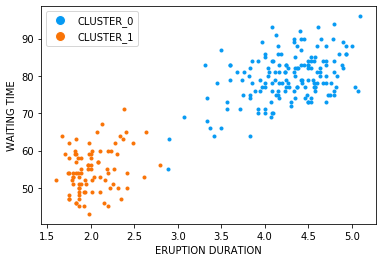

In [9]:
# predict cluster
clusters = clusterize(w)
plot_cluster(df_train,clusters)

In [10]:
# split clusters
cluster_0 = df_train.loc[ df_train["No"].isin( clusters[0] ) ]
cluster_1 = df_train.loc[ df_train["No"].isin( clusters[1] ) ]

### ```6.1.0``` Fit Regression Models to each individual cluster

In [11]:
# fit regression lines to both clusters
w_0 = train_linear(cluster_0,1,2,1,0.0000000000000000000001)
w_1 = train_linear(cluster_1,1,2,1,0.0000000000000000000001)

In [12]:
# regression weights
print(w_0)
print(w_1)

[ 9.96293903 35.46832624]
[10.9833719  33.24219076]


### ```7.1.0``` Test Data - Clusterize and fit regression

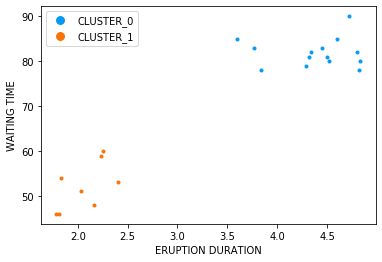

In [13]:
# test data clusters
test_wij = predict_em_wij(df_test[['duration']].values, u, sigma, phi)
test_clusters  = clusterize(test_wij)

predicted_y = np.ndarray((df_test.shape[0], 1))

for row in range(df_test.shape[0]):
    temp = df_test['duration'].iloc[row]
    if row in test_clusters[0]:
        predicted_y[row] = temp*w_0[0] + w_0[1]
    else:
        predicted_y[row] = temp*w_1[0] + w_0[1]
        
plot_cluster(df_test,test_clusters)

### ```7.2.0``` Test Data - Visualizing results

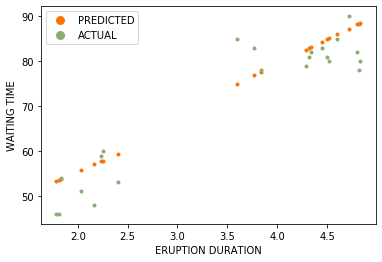

In [14]:
# predicted vs actual results
plt.plot(df_test["duration"],predicted_y, '.',color='xkcd:orange')
plt.plot(df_test["duration"],df_test["waiting"], '.',color='xkcd:sage')
plt.xlabel('ERUPTION DURATION')
plt.ylabel('WAITING TIME')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='PREDICTED',
                      markerfacecolor='xkcd:orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='ACTUAL',
                      markerfacecolor='xkcd:sage', markersize=10)
                   ]
# Create the figure
plt.legend(handles=legend_elements, loc='best')
plt.show()

### ```8.1.0``` Accuracy Score using R2

In [15]:
my_r2 = r2_score(df_test['waiting'],predicted_y)
df_r2 = pd.DataFrame([[my_r2]],columns=['MY R2 SCORE'])
df_r2.head()

,MY R2 SCORE
0,0.85894
